In [55]:
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import local_binary_pattern
import joblib
from joblib import load
import csv
import cv2
import io

In [125]:
dataset = pd.read_csv('Training.csv')

# dataset = dataset.drop(dataset.index[0])
# dataset.head()

# print(dataset)

# print(dataset.isnull().sum())

# print(dataset.info())

# print(dataset.describe())

In [137]:


# Pisahkan fitur dan target
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# latih menggunakan RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Prediksi label untuk data uji
y_pred = model.predict(X_test_scaled)

# Evaluasi performa model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      0.50      0.67         2
         2.0       0.00      0.00      0.00         0
         3.0       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.50      0.54         6
weighted avg       0.83      0.67      0.72         6



In [139]:
#untuk crop bagian wajah saja
def crop_face(image):
    # Load the pre-trained Haar Cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        # Assume the largest face in the image is the face of interest
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        x, y, w, h = largest_face
        face = image[y:y+h, x:x+w]
        return face

#confert to Grayscale
def convert2gray(image):
    return color.rgb2gray(image)

#Normalisasi image
def normalize_image(image, range_min=0, range_max=1):
    # Pastikan citra dalam format float untuk menghindari masalah pembulatan
    image = image.astype(np.float32)
    
    # Hitung nilai minimum dan maksimum dari citra
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Lakukan normalisasi
    normalized_image = (image - min_val) / (max_val - min_val)
    
    # Skalakan ke rentang yang diinginkan
    normalized_image = normalized_image * (range_max - range_min) + range_min
    
    return normalized_image

def extract_lbp_features(image, radius=3, n_points=8, method='uniform'):

    image = (image * 255).astype(np.uint8)

    # Hitung LBP
    lbp = local_binary_pattern(image, n_points, radius, method)

    # Hitung histogram LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalisasi histogram
    hist = hist.astype(float) / sum(hist)

    return hist


In [45]:
def citra_digital_test(image):
    image_cropped = crop_face(image)
    image_grayscale = convert2gray(image_cropped)
    image_normalizedd = normalize_image(image_grayscale)
    image_lab = extract_lbp_features(image_normalizedd)

    return image_lab

In [162]:
# image_test = cv2.imread("data/test_fuad.jpg")
# result_test = crop_face(image_test)
# result_test_2 = convert2gray(result_test)
# result_test_3 = extract_lbp_features(result_test_2)
# print(result_test_3)
# plt.imshow(result_test_2, cmap='gray')
# plt.axis('off')
# plt.title('Image')
# plt.show()

Hasil prediksi untuk data baru: 1.0
Hasil Prediksi: Haikal


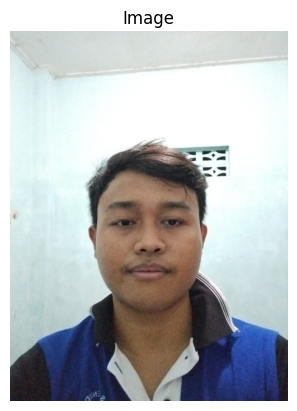

In [165]:
def main():
    image_path = "data/test_haikal.jpg"
    image = Image.open(image_path)
    image_test = np.array(image)
    result = citra_digital_test(image_test)
    
    new_data = np.array(result)
    
    array_reshaped = new_data.reshape(1, -1)
    
    # Penskalaan data menggunakan scaler yang sama dengan data latih
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_new_scaled = scaler.transform(array_reshaped)
    
    # Lakukan prediksi dengan model yang telah dilatih
    new_predictions = model.predict(X_new_scaled)
    
    # Cetak hasil prediksi
    print("Hasil prediksi untuk data baru:", new_predictions[0])
    
    # Interpretasi hasil prediksi
    if new_predictions[0] == 0.0:
        print("Hasil Prediksi: Riski")
    elif new_predictions[0] == 1.0:
        print("Hasil Prediksi: Haikal")
    elif new_predictions[0] == 2.0:
        print("Hasil Prediksi: Fuad")
    elif new_predictions[0] == 3.0:
        print("Hasil Prediksi: Fahrul")
    
    # print(result)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image')
    plt.show()

main()